In [1]:
import requests
import statsmodels.formula.api as smf    # for OLS regression
import pylab as pl
import pandas as pd
import numpy as np
import json
import urllib 
import scipy.stats
import os
import sys
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Download Data

In [2]:
def getCitiBikeCSV(datestring):
    '''Downloads citibike data and unzips it. If the data is downloaded by not unzippeds it zips it. Moves the data to $PUIDATA
    Arguments:
        date string as yyyymm
    '''
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [3]:
datestring1 = '201607'
getCitiBikeCSV(datestring1)
datestring2 = '201601'
getCitiBikeCSV(datestring2)

file in place, you can continue
file in place, you can continue


# Data Cleaning, we want to get usage information about one specific station: Lawrence St & Willoughby St

In [4]:
cb201607 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring1 + '-citibike-tripdata.csv')
cb201601 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring2 + '-citibike-tripdata.csv')

In [5]:
cb201607.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [6]:
cb201601.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [7]:
cb2016 = pd.concat([cb201607,cb201601],ignore_index=True)
len(cb2016)

1889588

In [8]:
cb2016

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,704,7/1/2016 00:00:02,7/1/2016 00:11:47,459,W 20 St & 11 Ave,40.746745,-74.007756,347,Greenwich St & W Houston St,40.728846,-74.008591,17431,Customer,NaN,0
1,492,7/1/2016 00:00:18,7/1/2016 00:08:31,293,Lafayette St & E 8 St,40.730287,-73.990765,466,W 25 St & 6 Ave,40.743954,-73.991449,24159,Subscriber,1984.0,1
2,191,7/1/2016 00:00:19,7/1/2016 00:03:31,3090,N 8 St & Driggs Ave,40.717746,-73.956001,3107,Bedford Ave & Nassau Ave,40.723117,-73.952123,16345,Subscriber,1986.0,2
3,687,7/1/2016 00:00:24,7/1/2016 00:11:52,459,W 20 St & 11 Ave,40.746745,-74.007756,347,Greenwich St & W Houston St,40.728846,-74.008591,25210,Customer,NaN,0
4,609,7/1/2016 00:00:31,7/1/2016 00:10:40,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,212,W 16 St & The High Line,40.743349,-74.006818,15514,Customer,NaN,0
5,672,7/1/2016 00:00:45,7/1/2016 00:11:57,459,W 20 St & 11 Ave,40.746745,-74.007756,347,Greenwich St & W Houston St,40.728846,-74.008591,15444,Subscriber,1991.0,1
6,466,7/1/2016 00:00:49,7/1/2016 00:08:35,128,MacDougal St & Prince St,40.727103,-74.002971,250,Lafayette St & Jersey St N,40.724561,-73.995653,14676,Subscriber,1989.0,1
7,556,7/1/2016 00:00:51,7/1/2016 00:10:07,433,E 13 St & Avenue A,40.729554,-73.980572,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,25755,Subscriber,1989.0,1
8,767,7/1/2016 00:00:51,7/1/2016 00:13:39,254,W 11 St & 6 Ave,40.735324,-73.998004,439,E 4 St & 2 Ave,40.726281,-73.989780,18871,Subscriber,1976.0,1
9,1442,7/1/2016 00:00:54,7/1/2016 00:24:56,515,W 43 St & 10 Ave,40.760094,-73.994618,511,E 14 St & Avenue B,40.729387,-73.977724,20381,Subscriber,1994.0,2


In [16]:
cb2016_out = cb2016[cb2016['start station name']=='Lawrence St & Willoughby St']
cb2016_in = cb2016[cb2016['end station name']=='Lawrence St & Willoughby St']

In [17]:
cb2016_out.loc[:,'hour'] = pd.to_datetime(cb2016_out.starttime).dt.hour
cb2016_in.loc[:,'hour'] = pd.to_datetime(cb2016_in.stoptime).dt.hour

/Users/cihe/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/cihe/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
cb2016_out.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,hour
43,662,7/1/2016 00:04:13,7/1/2016 00:15:16,323,Lawrence St & Willoughby St,40.692362,-73.986317,399,Lafayette Ave & St James Pl,40.688515,-73.964763,17325,Subscriber,1980.0,2,0
167,145,7/1/2016 00:14:43,7/1/2016 00:17:08,323,Lawrence St & Willoughby St,40.692362,-73.986317,310,State St & Smith St,40.689269,-73.989129,19376,Subscriber,1972.0,1,0
424,327,7/1/2016 00:41:54,7/1/2016 00:47:21,323,Lawrence St & Willoughby St,40.692362,-73.986317,157,Henry St & Atlantic Ave,40.690893,-73.996123,17229,Subscriber,1986.0,1,0
980,336,7/1/2016 02:49:36,7/1/2016 02:55:12,323,Lawrence St & Willoughby St,40.692362,-73.986317,270,Adelphi St & Myrtle Ave,40.693083,-73.971789,16468,Subscriber,1988.0,1,2
1179,142,7/1/2016 04:44:30,7/1/2016 04:46:53,323,Lawrence St & Willoughby St,40.692362,-73.986317,3232,Bond St & Fulton St,40.689622,-73.983043,18405,Subscriber,1955.0,1,4


In [19]:
cb2016_out =cb2016_out.groupby(['hour']).count()
cb2016_in = cb2016_in.groupby(['hour']).count()

# get intrip count and outtrip count, and we use intrip count minus outtrip count to get average balance

In [20]:
cb2016_out.rename(columns={"tripduration": "outtrip"},inplace = True)
cb2016_in.rename(columns={"tripduration": "intrip"},inplace = True)

In [21]:
cb2016_out.drop([u'starttime', u'stoptime',u'start station id', 'start station name',
                 u'start station latitude',u'start station longitude', u'end station id', 'end station name',
                 u'end station latitude', u'end station longitude',u'bikeid', u'usertype',
                 u'birth year', u'gender'], axis = 1, inplace = True)
cb2016_in.drop([u'starttime', u'stoptime',u'start station id', 'start station name',
                 u'start station latitude',u'start station longitude', u'end station id', 'end station name',
                 u'end station latitude', u'end station longitude',u'bikeid', u'usertype',
                 u'birth year', u'gender'], axis = 1, inplace = True)

In [22]:
cb2016_in.reset_index(inplace=True)
cb2016_out.reset_index(inplace=True)

merge all data into one dataframe and average the trip counts, also calculate average hourly balance

In [24]:
station_usage = cb2016_out.merge(cb2016_in, on='hour')
station_usage['outtrip'] = station_usage['outtrip'] / 62
station_usage['intrip'] = station_usage['intrip'] / 62
station_usage['balance'] = station_usage.intrip - station_usage.outtrip
station_usage

,hour,outtrip,intrip,balance
0,0,0.580645,0.451613,-0.129032
1,1,0.258065,0.129032,-0.129032
2,2,0.193548,0.129032,-0.064516
3,3,0.064516,0.048387,-0.016129
4,4,0.145161,0.193548,0.048387
5,5,0.193548,0.225806,0.032258
6,6,0.129032,1.403226,1.274194
7,7,1.032258,1.677419,0.645161
8,8,2.483871,6.209677,3.725806
9,9,1.758065,6.193548,4.435484


# Plot average hour intrip, outtrip and balance

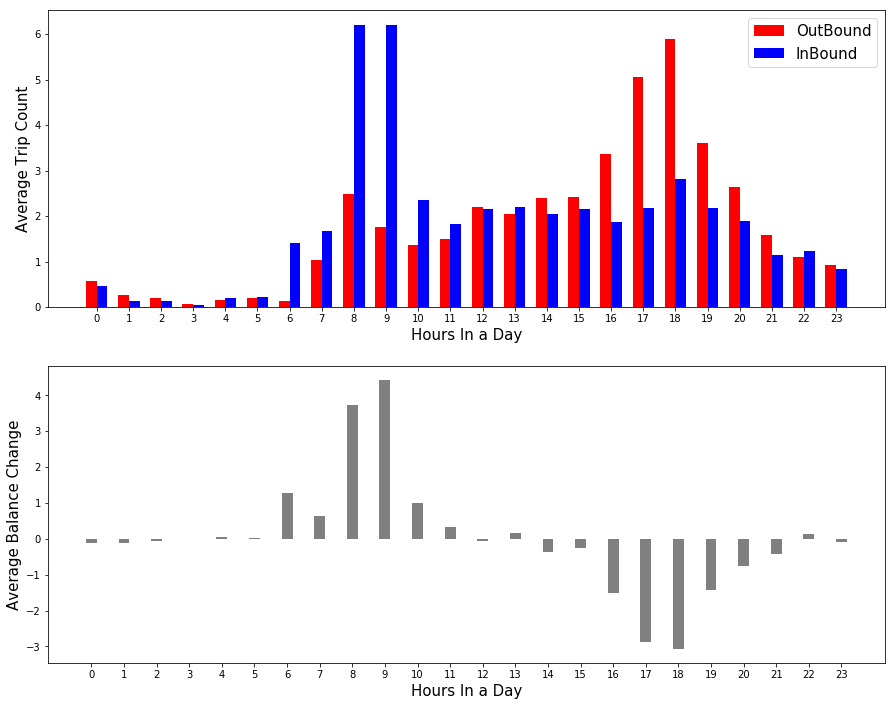

In [39]:
indices = station_usage.hour
#Calculate optimal width
width = np.min(np.diff(indices))/3

fig = plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(211)
ax1.bar(indices-width/2,station_usage.outtrip,width,color='r',label='OutBound')
ax1.bar(indices+width/2,station_usage.intrip,width,color='b',label='InBound')
ax1.set_xlabel('Hours In a Day',fontsize=15)
ax1.set_ylabel('Average Trip Count',fontsize=15)
ax1.set_xticks(station_usage.hour)
#ax1.set_title('CitiBike Lawrence St & Willoughby St July,2016&Jan,2016 Average In&Out Amount',fontsize=18)
ax1.legend(fontsize=15)

ax2 = fig.add_subplot(212)
ax2.bar(indices,station_usage.balance,width,color='grey',label='Bike Balance Change')
ax2.set_xlabel('Hours In a Day',fontsize=15)
ax2.set_xticks(station_usage.hour)
ax2.set_ylabel('Average Balance Change',fontsize=15)
#ax2.set_title('CitiBike Lawrence St & Willoughby St 201607&201601 Average Balance Change',fontsize=18)
#ax2.legend(fontsize=20)

plt.show()

# Figure1:CitiBike Lawrence St & Willoughby St July & Jan,2016 Average Hourly In&Out Trip-Count and Balance Change

We can see from the plots, there is an obvious usage pattern on this CitiBike Station: more inbound bikes in the morning(especially at 8&9 o'clock) while more outbound bikes in the afternoon(5pm&6pm). Since the station sits right next to our school location and many other offices, this result can be explained by people using CitiBike to get to school/work in the morning and to get back home in the evening.